In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb

In [2]:
# 参数定义
r_mean = 1.0  # 平均增长率
D = 1e-6  # 迁移率
A_mean_range = [0.75, 1.25]  # 平均抑制系数范围
ystep = 21  # A_mean 的步数
sstep = 5 # A_mean 的步数


T_real = 1000  # 总进化时间
step = 0.05  # 时间间隔
T = int(np.ceil(T_real / step))  # 循环次数
num_sim = 30  # 系综平均次数
period = 200  # 用于计算丰富度的持续时间
abundance_threshold = 1e-3  # 物种生存的丰度阈值

# 初始化记录矩阵
fluc_record = np.zeros((sstep , ystep, num_sim))
diversity_record = np.zeros((sstep , ystep, num_sim))



fluc_mean = np.zeros((sstep , ystep))
div_mean = np.zeros((sstep , ystep))

A_mean = np.linspace(A_mean_range[0], A_mean_range[1], ystep)
print(A_mean)
ss = np.zeros(sstep)
for i in range(sstep):
    ss[i] = 10*np.power(2,i)

[0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025
 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25 ]


In [3]:
@jit(nopython=True)
def LV_compute( AA,A_m, S):

    N_mean = 0.5
    NN = np.zeros((T, S))
    r = np.ones(S)
    
    N0 = np.ones(S)*N_mean
    NN[0] = N0
    Migra = np.ones(S) * D
    
    for i in range(1, T):
        
        k1 = r * NN[i-1] * (1- np.dot(AA, NN[i-1]))* step
        k2 = r * (NN[i-1]+k1/2) * (1- np.dot(AA, NN[i-1]+k1/2))*step
        k3 = r * (NN[i-1]+k2/2) * (1- np.dot(AA, NN[i-1]+k2/2))*step
        k4 = r * (NN[i-1]+k3) * (1- np.dot(AA, NN[i-1]+k3))*step
        #NN[i] = NN[i-1] + r * NN[i-1] * (1- np.dot(AA, NN[i-1])) * step
        NN[i] = NN[i-1]+ (k1+2*k2+2*k3+k4)/6
        NN[i] += Migra  # 添加迁移
        
    return NN

In [4]:
@jit(nopython=True)
def axis_of_cols(matrix, num_cols):
    maxc = np.zeros(num_cols)
    flucc= np.zeros(num_cols)
    matrix_2 = matrix.T
    richness =0
    
    for i in range(num_cols):       
        maxc[i] =  np.max(matrix_2[i])
        if maxc[i]> abundance_threshold:
            richness+=1
            mean_v = np.mean(matrix_2[i])
            if mean_v!=0 and not np.isnan(np.std(matrix_2[i]) /mean_v):
                flucc[i] = np.std(matrix_2[i]) /mean_v

    return  richness, flucc

In [5]:
@jit(nopython=True)
def MatrixGen(S, A):
    p= 10/S
    adj_matrix = np.zeros((S, S))
    AA = np.zeros((S,S))
    # Generate edges
    for i in range(S):
        for j in range(i + 1, S):
            if np.random.rand() < p:
                adj_matrix[i, j] = adj_matrix[j, i] = 1
                AA[i,j]          = AA[j,i]          = np.random.randn()*A/36+A
                if np.random.rand() < 0.5:
                    adj_matrix[i,j] = -1
                    AA[i,j]         = -1*AA[j,i]

    adj_matrix = adj_matrix+ np.eye(S)
    AA=AA+np.eye(S)
    
    
    return adj_matrix, AA

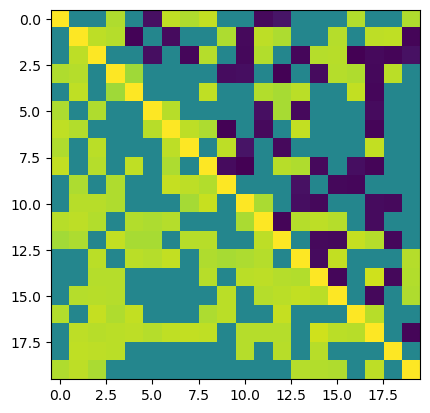

In [6]:
adjacency_matrix, AA = MatrixGen(20, 0.8)
#plt.imshow(np.abs(adjacency_matrix))
plt.imshow(AA)

In [7]:
sstep =5
num_sim = 10
Ss = np.array([10,11,14,20,40])
diversity_record = np.zeros((sstep , ystep, num_sim))
fluc_record = np.zeros((sstep , ystep, num_sim))
div_mean = np.zeros((sstep , ystep))
fluc_mean = np.zeros((sstep , ystep))
for pp in range(sstep):
    S= Ss[pp]
    print("S=",S)
    for yy in range(ystep):
        for hh in range(num_sim):
            # 调用 LV_compute 函数来计算组成
            
            adjacency_matrix, AA = MatrixGen(S, A_mean[yy])
            composition = LV_compute( AA, A_mean[yy],S )
            richness,fluc_CV = axis_of_cols(composition[T - period:T], S)
            diversity_record[pp , yy, hh] = richness / S
            fluc_record[pp, yy, hh] = np.sum(fluc_CV)/richness
        div_mean[pp,yy] = np.mean(diversity_record[pp,yy])
        fluc_mean[pp,yy]= np.sum(fluc_record[pp,yy]*diversity_record[pp,yy])/np.sum(diversity_record[pp,yy])


S= 10
S= 11
S= 14
S= 20
S= 40


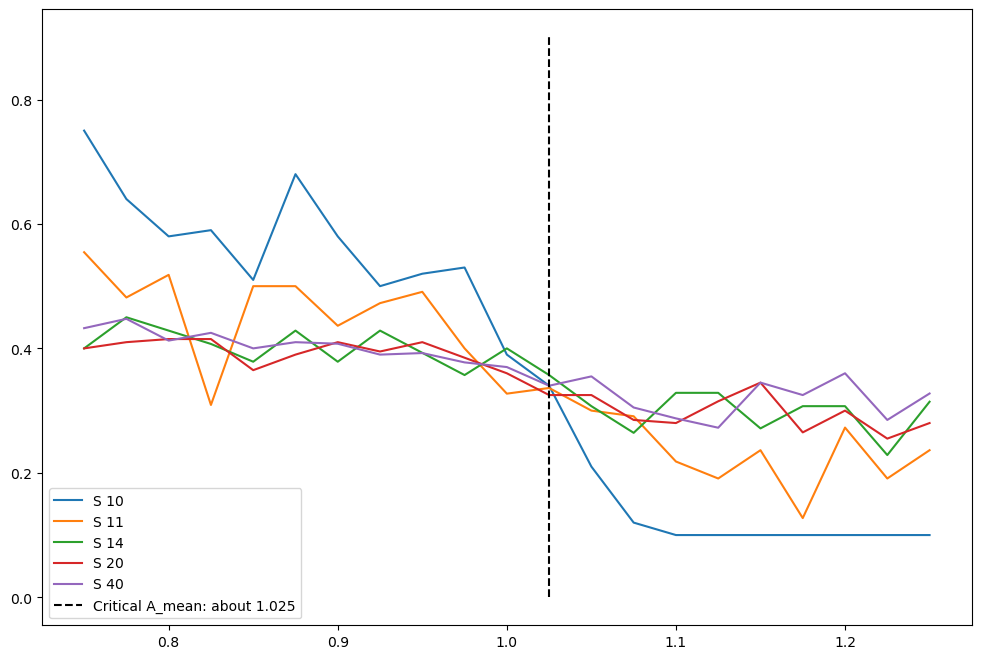

In [8]:
plt.figure(figsize=(12, 8))
S=10
for i in range(sstep):
    
    plt.plot(A_mean,div_mean[i,:],label=f"S {Ss[i]}")

xxx= np.ones(10)*1.025
yyy= np.arange(10)*0.1
plt.plot(xxx,yyy,linestyle='--', color = 'black',label=f"Critical A_mean: about {1.025}")

plt.legend(loc='lower left')
plt.show()

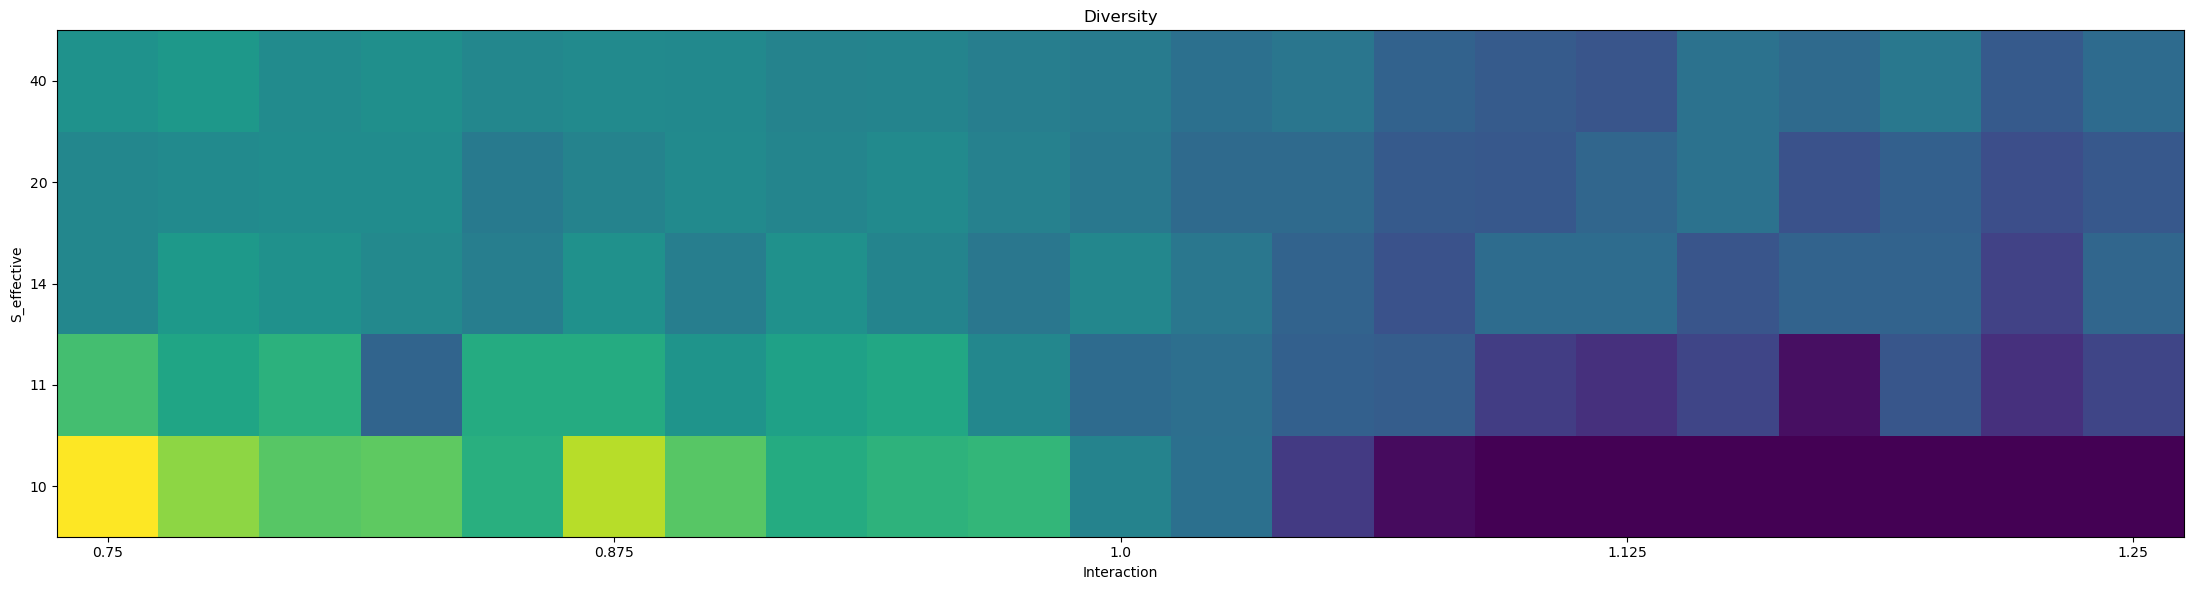

In [9]:
plt.figure(figsize=(30, 6))
plt.imshow(div_mean,origin='lower')
plt.xticks(np.arange(0,ystep,5),A_mean[::5])
plt.yticks(np.arange(0,sstep,1),Ss)
plt.xlabel("Interaction")  # 设置横轴标签
plt.ylabel("S_effective")  # 设置纵轴标签
plt.title("Diversity")   # 设置标题（可选）
plt.tight_layout()
plt.show()

In [10]:
def plot_3d_matrix(matrix):
    rows, cols = matrix.shape

    # 创建 X 和 Y 坐标
    
    #X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    X, Y = np.meshgrid(Ss, A_mean)

    # 绘制三维图
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 使用矩阵值作为 Z 坐标
    Z = matrix

    # 绘制曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # 设置标题和标签
    ax.set_title('3D Matrix Visualization')
    A_mean_p = A_mean
    ps_p = Ss
    A_mean_p= np.around(A_mean_p,3)
    ps_p = np.around(ps_p,3)
    ax.set_yticks(A_mean_p[::5])
    ax.set_xticks(ps_p[:])
    ax.set_xlabel('p')
    ax.set_ylabel('Interaction')
    ax.set_zlabel('Matrix Value')

    plt.show()

In [11]:
def plot_3d_matrix_ori(matrix):
    rows, cols = matrix.shape

    # 创建 X 和 Y 坐标
    
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    #X, Y = np.meshgrid(ps, A_mean)

    # 绘制三维图
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 使用矩阵值作为 Z 坐标
    Z = matrix

    # 绘制曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=10)
    A_mean_p = A_mean
    ps_p = Ss
    A_mean_p = np.around(A_mean_p,3)
    ps_p = np.around(ps_p,3)
    # 设置标题和标签
    ax.set_title('3D Matrix Visualization')
    ax.set_yticks(np.arange(0,ystep,5),A_mean_p[::5])
    ax.set_xticks(np.arange(0,sstep,1),ps_p[:])
    ax.set_xlabel('p')
    ax.set_ylabel('Interaction')
    ax.set_zlabel('Matrix Value')

    plt.show()

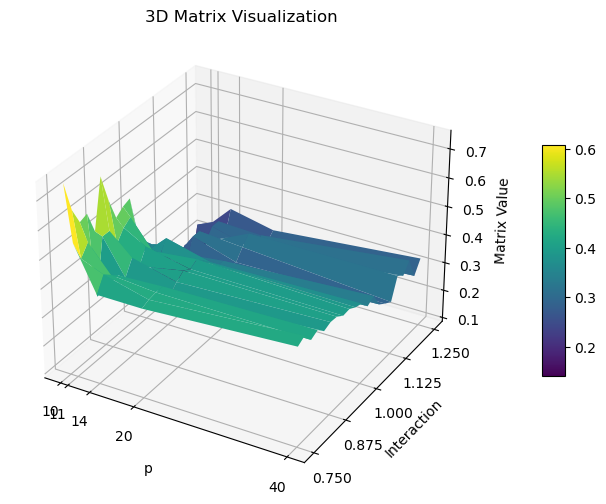

In [12]:
plot_3d_matrix(div_mean.T)

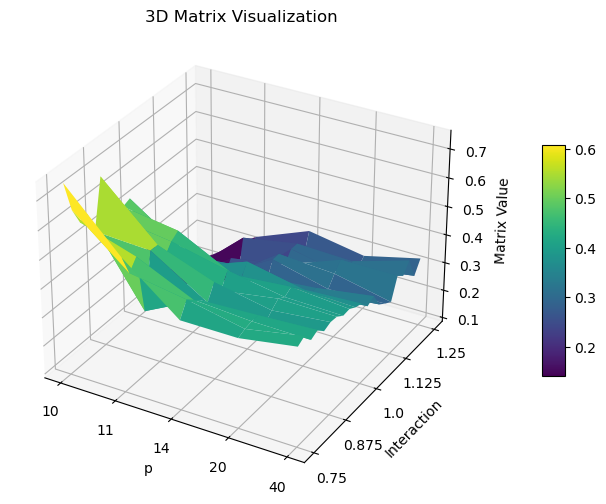

In [13]:
plot_3d_matrix_ori(div_mean.T)

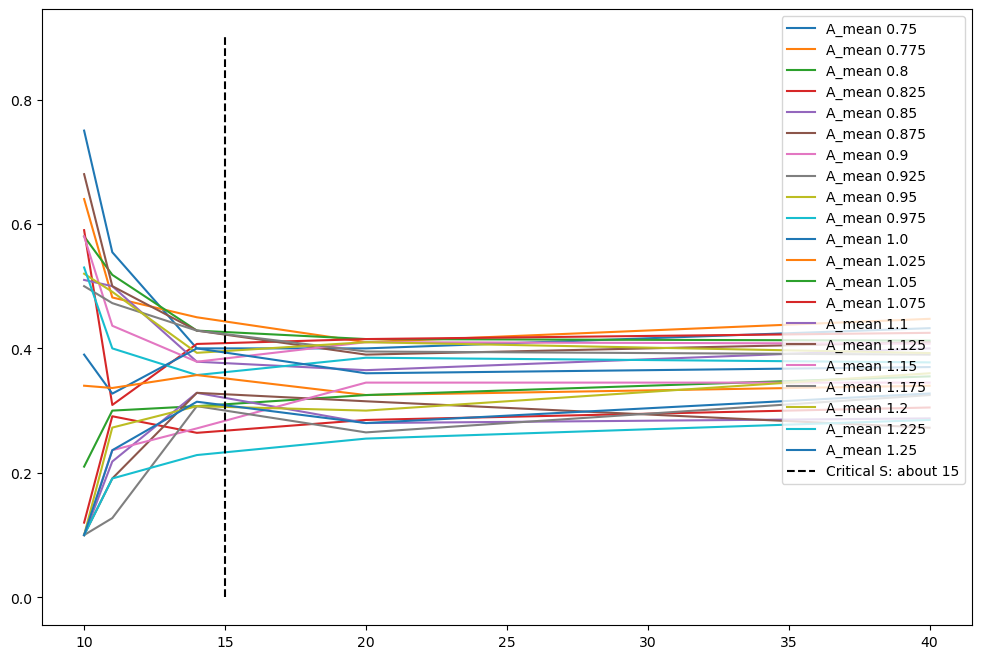

In [14]:
plt.figure(figsize=(12, 8))
for i in range(ystep):
    plt.plot(Ss[:],div_mean[:,i],label=f"A_mean {A_mean[i]}")

xxx= np.ones(10)*15
yyy= np.arange(10)*0.1
plt.plot(xxx,yyy,linestyle='--', color = 'black',label=f"Critical S: about {15}")
plt.legend(loc='upper right')
plt.show()